K-NNs to predict local values of total strain 


In [114]:
Data_sims_file = "C:\\Users\\Mehdi-GHRABLI\\Desktop\\New_Launch\\New_launch_files\\user_files" #Data_sims_file is the folder containing the simulation results


In [115]:
# Defining metrics : 
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
import os #Used to get Data path
import pandas as pd #Used to create dataframe
import numpy as np #Used to calculate values in dataframe (plasticity for example)
import matplotlib.pyplot as plt 
from tqdm import tqdm
# import scipy.stats
import numpy as np
import scipy.interpolate
# from sklearn.model_selection import train_test_split
# from ISLP import load_data , confusion_table
from ISLP.models import ModelSpec as MS
# from keras.models import Sequential
# from keras.layers import Dense
# import keras
import sklearn.model_selection as skm
import time
from datetime import timedelta
# from sklearn.datasets import make_regression
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.colors as mcolors
np.random.seed(1)

def metric_MSE(ground_truth,predictions):
    return mean_squared_error(ground_truth,predictions)
def metric_MAE(ground_truth,predictions):
    return mean_absolute_error(ground_truth,predictions)
def metric_R2(ground_truth,predictions):
    return r2_score(ground_truth,predictions)
def metric_adjusted_R2(ground_truth,predictions,n_obs,n_indep_variables):
    return 1-(1-r2_score(ground_truth,predictions))*(n_obs-1)/(n_obs-n_indep_variables-1)
def metric_MAPE(ground_truth,predictions):
    return np.mean(np.abs((ground_truth - predictions) / ground_truth))*100

def metric_MSPE(ground_truth, predictions, eps=1e-8):
    ground_truth, predictions = np.array(ground_truth).ravel(), np.array(predictions).ravel()
    return np.mean(np.square((ground_truth - predictions) / np.maximum(np.abs(ground_truth), eps))) * 100

def adaptive_MAPE(y_true, y_pred, min_eps=1e-8):
    y_true = np.ravel(np.array(y_true, dtype=np.float64))
    y_pred = np.ravel(np.array(y_pred, dtype=np.float64))    
    scale_eps = max(min_eps, np.mean(np.abs(y_true)) * 1e-6)
    perc_error = np.abs(y_true - y_pred) / np.maximum(np.abs(y_true), scale_eps)
    return np.mean(perc_error) * 100

def adaptive_MSPE(y_true, y_pred, min_eps=1e-8):
    y_true = np.ravel(np.array(y_true, dtype=np.float64))
    y_pred = np.ravel(np.array(y_pred, dtype=np.float64))
    
    scale_eps = max(min_eps, np.mean(np.abs(y_true)) * 1e-6)
    perc_error_sq = np.square((y_true - y_pred) / np.maximum(np.abs(y_true), scale_eps))
    return np.mean(perc_error_sq) * 100

In [116]:
def plot_residuals(X_test,y_hat,y_test,local_contact_data,Input_names,Output_names):
    def plot_residuals_per_variable(X_test,Variable_name,e):
        plt.scatter(np.array(X_test)[:,e].reshape(-1)*float(local_contact_data[Variable_name].max()-local_contact_data[Variable_name].min())+float(local_contact_data[Variable_name].min()),residuals*float(local_contact_data[Output_names].max().iloc[0]-local_contact_data[Output_names].min().iloc[0])+float(local_contact_data[Output_names].min().iloc[0]))
        plt.axhline(0, c='k', ls='--')
        plt.xlabel(Variable_name)
        plt.grid()
        plt.ylabel("Residuals")
        plt.show()
        return
    residuals = y_hat-y_test.reshape(-1)
    plt.scatter(y_test.reshape(-1)*float(local_contact_data[Output_names].max().iloc[0]-local_contact_data[Output_names].min().iloc[0])+float(local_contact_data[Output_names].min().iloc[0]),residuals*float(local_contact_data[Output_names].max().iloc[0]-local_contact_data[Output_names].min().iloc[0])+float(local_contact_data[Output_names].min().iloc[0]))
    plt.axhline(0, c='k', ls='--')
    plt.xlabel("Total strain")
    plt.ylabel("Residuals")
    plt.grid()
    plt.show()

    plt.scatter(y_test.reshape(-1)*float(local_contact_data[Output_names].max().iloc[0]-local_contact_data[Output_names].min().iloc[0])+float(local_contact_data[Output_names].min().iloc[0]),y_hat*float(local_contact_data[Output_names].max().iloc[0]-local_contact_data[Output_names].min().iloc[0])+float(local_contact_data[Output_names].min().iloc[0]))
    plt.plot(y_test*float(local_contact_data[Output_names].max().iloc[0]-local_contact_data[Output_names].min().iloc[0])+float(local_contact_data[Output_names].min().iloc[0]),y_test*float(local_contact_data[Output_names].max().iloc[0]-local_contact_data[Output_names].min().iloc[0])+float(local_contact_data[Output_names].min().iloc[0]),color='red')
    plt.xlabel("Total strain")
    plt.ylabel("predicted strain")
    plt.grid()
    plt.show()
    for e,input_name in enumerate(Input_names):
        plot_residuals_per_variable(X_test,input_name,e)

    
    return

Importing Data

In [117]:
n_exp = 1000
Design_point_folders = [ f.path for f in os.scandir(Data_sims_file) if f.is_dir() ]


In [118]:
Names_list = []
Current_list = []
Rh_list = []
Rw_list = []
Alpha_list = []
Temperature_list = []


Suff_contact= [" Contact Time 1.txt"," Contact Time 2.txt"]
Suff_metal= [" Metal Time 1.txt"," Metal Time 2.txt"]

Initial_local_names = [
    "Directional Deformation X",
    "Directional Deformation Y",
    "Directional Deformation Z",
    "Elastic Strain Intensity",
    "Equivalent Elastic Strain",
    "Equivalent Plastic Strain",
    "Equivalent Stress",
    "Equivalent Total Strain",
    "Maximum Principal Elastic Strain",
    "Maximum Principal Stress",
    "Maximum Shear Elastic Strain",
    "Maximum Shear Stress",
    "Middle Principal Elastic Strain",
    "Middle Principal Stress",
    "Minimum Principal Elastic Strain",
    "Minimum Principal Stress",
    "Normal Elastic Strain X",
    "Normal Elastic Strain Y",
    "Normal Elastic Strain Z",
    "Normal Stress X",
    "Normal Stress Y",
    "Normal Stress Z",
    "Shear Elastic Strain XY",
    "Shear Elastic Strain XZ",
    "Shear Elastic Strain YZ",
    "Shear Stress XY",
    "Shear Stress XZ",
    "Shear Stress YZ",
    "Stress Intensity",
    "Thermal Strain X",
    "Thermal Strain Y",
    "Thermal Strain Z",
    "Total Deformation"
]

Suff_ab_contact = ["_C1","_C2"]
Suff_ab_metal = ["_M1","_M2"]
Initial_local_names_ab = ["DDX","DDY","DDZ","ESI","EES","EPS","ES","ETS","MaxPES","MaxPS","MaxSES","MaxSS","MidPES","MidPS","MinPES","MinPS","NESX","MESY","NESZ","NSX","NSY","NSZ","SESXY","SESXZ","SESYZ","SSXY","SSXZ","SSYZ","SI","TSX","TSY","TSZ","TD"]

Final_local_names_contact = []
Final_local_names_metal = []

Final_local_ab_contact = []
Final_local_ab_metal = []



for i in Initial_local_names:
  for sC in Suff_contact:
    Final_local_names_contact.append(i+sC)
  for sM in Suff_metal:
    Final_local_names_metal.append(i+sM)

for i in Initial_local_names_ab:
  for sC in Suff_ab_contact:
    Final_local_ab_contact.append(i+sC)
  for sM in Suff_ab_metal:
    Final_local_ab_metal.append(i+sM)




In [119]:
#Contact
local_contact_data = pd.DataFrame()
#Add origin
for sf in tqdm(Design_point_folders[:n_exp]):
  subfolder_name = sf.split('\\')[-1]
  Names_list.append(subfolder_name)
  #Get average temperature
  try:
    file = open(sf + "/Average_Chip_Temperature.txt", "r")
    file_content=file.readlines()[0]
    str_temp = file_content.split(" ")[0]
    temp = float(str_temp)
    Temperature_list.append(temp)
    file.close()
  except :
    pass


  try:
    file = open(sf + "/Params.txt", "rb")
    content=file.readlines()
    Current_st = content[4]
    Current_value = float(Current_st.decode("utf-8").split(" ")[-1][:-3])
    Current_list.append(Current_value)
    Rh_st = content[5]
    Rh_value = float(Rh_st.decode("utf-8").split(" ")[-1][:-3])
    Rh_list.append(Rh_value)
    Rw_st = content[6]
    Rw_value = float(Rw_st.decode("utf-8").split(" ")[-1][:-3])
    Rw_list.append(Rw_value)
    alpha_st = content[7]
    Alpha_value = float(alpha_st.decode("utf-8").split(" ")[-1][:-3])
    Alpha_list.append(Alpha_value)
    file.close()
  except :
    pass

  inst_df = pd.DataFrame()
  for ind, inst in enumerate(Final_local_names_contact):
    f_data = pd.read_csv(sf + "/"+inst,sep = "\t")
    inst_df[Final_local_ab_contact[ind]]=f_data[f_data.columns[-1]].str.replace(',','.').astype(float)

  file = open(sf + "/Origin.txt", "r")
  file_content=file.readlines()
  X_or = float(file_content[0].split(" ")[-1][:-2])
  Y_or = float(file_content[1].split(" ")[-1][:-2])
  Z_or = float(file_content[2].split(" ")[-1][:-2])
  file.close()

  inst_df["Names"] = subfolder_name
  inst_df["Temperature (°C)"] = temp
  inst_df["Current (mA)"] = Current_value
  inst_df["Contact major radius (mm)"] = Rh_value
  inst_df["Contact minor radius (mm)"] = Rw_value
  inst_df["Alpha"] = Alpha_value
  inst_df["X (mm)"]=(f_data[f_data.columns[1]].str.replace(',','.').astype(float)-X_or)/Rw_value
  inst_df["Y (mm)"]=(f_data[f_data.columns[2]].str.replace(',','.').astype(float)-Y_or)/Rh_value
  inst_df["Z (mm)"]=f_data[f_data.columns[3]].str.replace(',','.').astype(float)-Z_or
  local_contact_data =pd.concat([local_contact_data,inst_df])




  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [05:28<00:00,  3.04it/s]


Pre-processing

In [120]:
Random_contact_index = np.random.randint(n_exp,len(Design_point_folders))
#Contact
Random_contact_data = pd.DataFrame()
#Add origin
rsf = Design_point_folders[Random_contact_index]
subfolder_name = rsf.split('\\')[-1]
file = open(rsf + "/Average_Chip_Temperature.txt", "r")
file_content=file.readlines()[0]
str_temp = file_content.split(" ")[0]
temp = float(str_temp)
file.close()
file = open(rsf + "/Params.txt", "rb")
content=file.readlines()
Current_st = content[4]
Current_value = float(Current_st.decode("utf-8").split(" ")[-1][:-3])
Rh_st = content[5]
Rh_value = float(Rh_st.decode("utf-8").split(" ")[-1][:-3])
Rw_st = content[6]
Rw_value = float(Rw_st.decode("utf-8").split(" ")[-1][:-3])
alpha_st = content[7]
Alpha_value = float(alpha_st.decode("utf-8").split(" ")[-1][:-3])
file.close()
for ind, inst in enumerate(Final_local_names_contact):
  f_data = pd.read_csv(rsf + "/"+inst,sep = "\t")
  Random_contact_data[Final_local_ab_contact[ind]]=f_data[f_data.columns[-1]].str.replace(',','.').astype(float)

file = open(rsf + "/Origin.txt", "r")
file_content=file.readlines()
X_or = float(file_content[0].split(" ")[-1][:-2])
Y_or = float(file_content[1].split(" ")[-1][:-2])
Z_or = float(file_content[2].split(" ")[-1][:-2])
file.close()

Random_contact_data["Names"] = subfolder_name
Random_contact_data["Temperature (°C)"] = temp
Random_contact_data["Current (mA)"] = Current_value
Random_contact_data["Contact major radius (mm)"] = Rh_value
Random_contact_data["Contact minor radius (mm)"] = Rw_value
Random_contact_data["Alpha"] = Alpha_value
Random_contact_data["X (mm)"]=(f_data[f_data.columns[1]].str.replace(',','.').astype(float)-X_or)
Random_contact_data["Y (mm)"]=(f_data[f_data.columns[2]].str.replace(',','.').astype(float)-Y_or)
Random_contact_data["Z (mm)"]=f_data[f_data.columns[3]].str.replace(',','.').astype(float)-Z_or

local_contact_data = local_contact_data.loc[local_contact_data["Temperature (°C)"]>20]
Input_names = ["Temperature (°C)","Contact major radius (mm)","X (mm)","Y (mm)"]
Output_names = ["ETS_C1"]
Reduced_full = local_contact_data[Input_names+Output_names]
Reduced_full = Reduced_full.sample(frac=1).reset_index(drop=True)
Reduced_full = (Reduced_full-Reduced_full.min())/(Reduced_full.max()-Reduced_full.min())
Input_data =  Reduced_full[Input_names]
Output_data = Reduced_full[Output_names]


In [121]:
Residual_variable_names = ["Temperature (°C)","Contact major radius (mm)","X (mm)","Y (mm)"]

Decompose data to analyse learning behavior 

In [122]:
Input_data_for_consistency = dict()
Output_data_for_consistency = dict()
Full_data_for_consistency = dict()

for i in range(10):
    Input_data_for_consistency[i] = Input_data[:(i+1)*(len(Input_data)//10)]
    Output_data_for_consistency[i] = Output_data[:(i+1)*(len(Output_data)//10)]
    Full_data_for_consistency[i] = Reduced_full[:(i+1)*(len(Reduced_full)//10)]


Hyper parameter tuning 

In [123]:
Number_of_splits = 5
kf = skm.KFold(n_splits=Number_of_splits,random_state=1,shuffle=True)
Fitting_data_hyper = Full_data_for_consistency[9]
Numb_neighbours = [5,6,7,8,9,10,11,12,13,14,15]
Logs_metrics = dict()
for d in tqdm(range(len(Full_data_for_consistency))):
    used_data = Full_data_for_consistency[d]
    Eval_Hyper = pd.DataFrame(columns=["Neighbours","MSE","MSE_std","MAE","MAE_std","R2","R2_std","AdjR2","AdjR2_std"])
    for neigh in Numb_neighbours : 
        MSEs = []
        MAEs = []
        R2s = []
        Adjusted_R2s = []
        for fold,(train_ids, valid_ids) in enumerate(kf.split(used_data)): 

            Xtrain = used_data.loc[train_ids,Input_names]
            ytrain = used_data.loc[train_ids,Output_names]
            Xvalid = used_data.loc[valid_ids,Input_names]
            yvalid = used_data.loc[valid_ids,Output_names]

            knn_regressor = KNeighborsRegressor(n_neighbors=neigh)
            knn_regressor.fit(Xtrain, ytrain)
            y_hat = knn_regressor.predict(Xvalid)


            MSE = metric_MSE(yvalid,y_hat)
            MAE = metric_MAE(yvalid,y_hat)
            R2 = metric_R2(yvalid,y_hat)
            Adjusted_R2 = metric_adjusted_R2(yvalid,y_hat,len(ytrain),Xtrain.shape[1])
            MSEs.append(MSE)
            MAEs.append(MAE)
            R2s.append(R2)
            Adjusted_R2s.append(Adjusted_R2)
        Eval_Hyper.loc[-1] =[neigh,np.mean(MSEs),np.std(MSEs),np.mean(MAEs),np.std(MAEs),np.mean(R2s),np.std(R2s),np.mean(Adjusted_R2s),np.std(Adjusted_R2s)]  # adding a row
        Eval_Hyper.index = Eval_Hyper.index + 1  # shifting index
        Eval_Hyper = Eval_Hyper.sort_index()  # sorting by index
    Logs_metrics[d]=Eval_Hyper

100%|██████████| 10/10 [04:34<00:00, 27.43s/it]


Plotting 

In [124]:
MSEs = []
std_MSEs =[] 
MAEs = []
std_MAEs = [] 
R2s = []
std_R2s = []
Adj_R2s = []
std_Adj_R2s = []
Train_data_sizes = []
Params_MSE = []
Params_MAE = []
Params_R2 = []
Params_Adjusted_R2 = []
for d in Full_data_for_consistency:
    Train_data_sizes.append(len(Full_data_for_consistency[d]))
    MSEs.append(Logs_metrics[d]["MSE"][Logs_metrics[d]["MSE"].idxmin()])
    std_MSEs.append(Logs_metrics[d]["MSE_std"][Logs_metrics[d]["MSE"].idxmin()])

    MAEs.append(Logs_metrics[d]["MAE"][Logs_metrics[d]["MAE"].idxmin()])
    std_MAEs.append(Logs_metrics[d]["MAE_std"][Logs_metrics[d]["MAE"].idxmin()])

    R2s.append(Logs_metrics[d]["R2"][Logs_metrics[d]["R2"].idxmax()])
    std_R2s.append(Logs_metrics[d]["R2_std"][Logs_metrics[d]["R2"].idxmax()])

    Adj_R2s.append(Logs_metrics[d]["AdjR2"][Logs_metrics[d]["AdjR2"].idxmax()])
    std_Adj_R2s.append(Logs_metrics[d]["AdjR2_std"][Logs_metrics[d]["AdjR2"].idxmax()])

    Params_MSE.append(Logs_metrics[d]["Neighbours"][Logs_metrics[d]["MSE"].idxmin()])
    Params_MAE.append(Logs_metrics[d]["Neighbours"][Logs_metrics[d]["MAE"].idxmin()])
    Params_R2.append(Logs_metrics[d]["Neighbours"][Logs_metrics[d]["R2"].idxmax()])
    Params_Adjusted_R2.append(Logs_metrics[d]["Neighbours"][Logs_metrics[d]["AdjR2"].idxmax()])



    


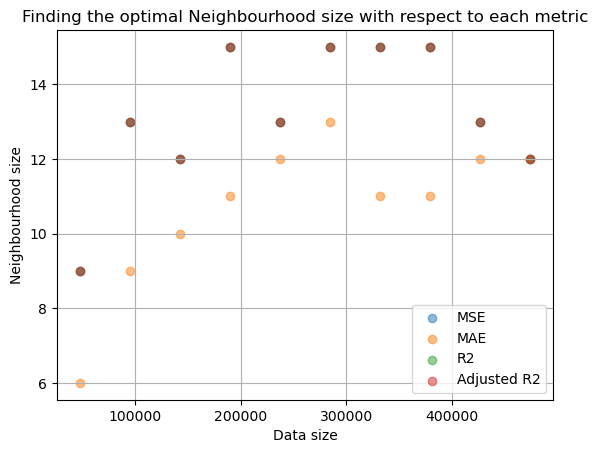

In [125]:
plt.scatter(Train_data_sizes,Params_MSE,label="MSE",alpha=0.5)
plt.scatter(Train_data_sizes,Params_MAE,label="MAE",alpha=0.5)
plt.scatter(Train_data_sizes,Params_R2,label="R2",alpha=0.5)
plt.scatter(Train_data_sizes,Params_Adjusted_R2,label="Adjusted R2",alpha=0.5)
plt.legend()
plt.title("Finding the optimal Neighbourhood size with respect to each metric")
plt.xlabel("Data size")
plt.ylabel("Neighbourhood size")
plt.grid()

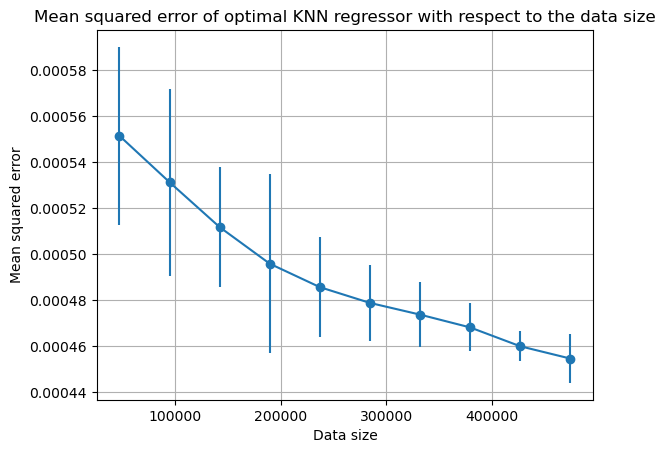

In [126]:
plt.errorbar(Train_data_sizes, MSEs, yerr=std_MSEs, label='MSE',fmt='-o')
plt.title("Mean squared error of optimal KNN regressor with respect to the data size")
plt.xlabel("Data size")
plt.ylabel("Mean squared error")
plt.grid()

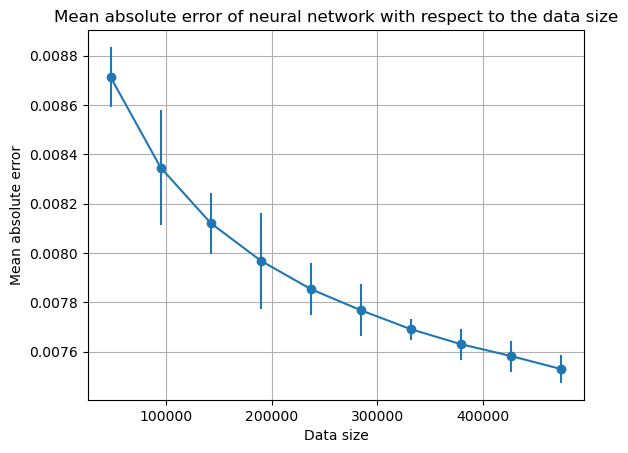

In [127]:
plt.errorbar(Train_data_sizes, MAEs , yerr=std_MAEs,  label='MAE',fmt='-o')
plt.title("Mean absolute error of neural network with respect to the data size")
plt.xlabel("Data size")
plt.ylabel("Mean absolute error")
plt.grid()

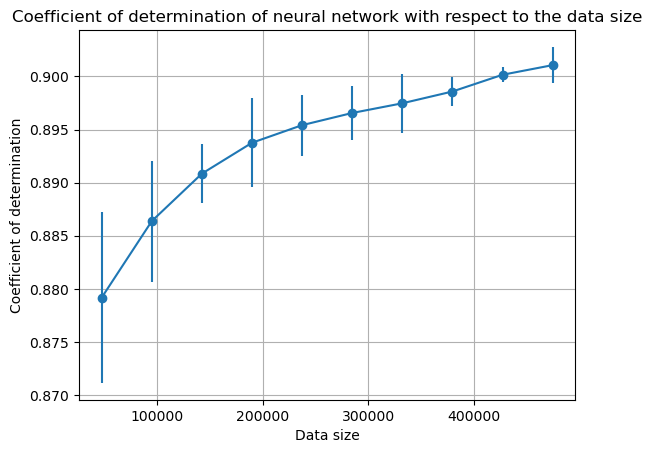

In [128]:
plt.errorbar(Train_data_sizes, R2s, yerr=std_R2s,label='R2',fmt='-o')
plt.title("Coefficient of determination of neural network with respect to the data size")
plt.xlabel("Data size")
plt.ylabel("Coefficient of determination")
plt.grid()

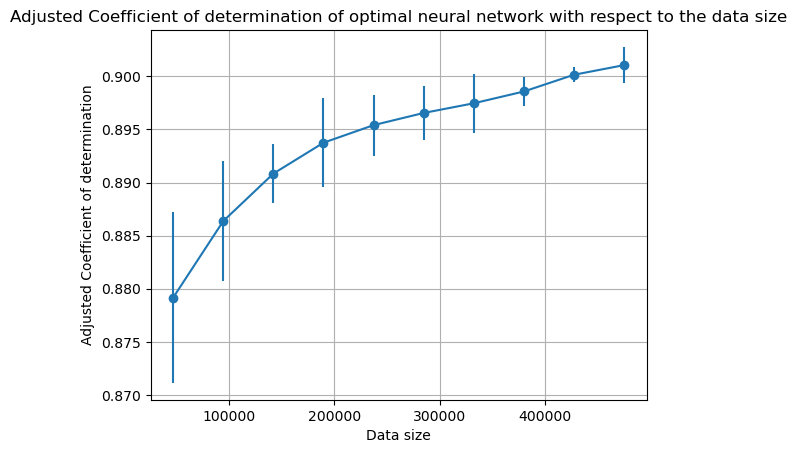

In [129]:
plt.errorbar(Train_data_sizes, Adj_R2s, yerr=std_Adj_R2s, label='Adjusted R2',fmt='-o')
plt.title("Adjusted Coefficient of determination of optimal neural network with respect to the data size")
plt.xlabel("Data size")
plt.ylabel("Adjusted Coefficient of determination")
plt.grid()

Verdict 

In [130]:
Fitting_data_consistency = Full_data_for_consistency[9]

In [131]:
model = MS(Fitting_data_consistency.columns.drop(Output_names), intercept=False)
D = model.fit_transform(Fitting_data_consistency)
feature_names = list(D.columns)
X = np.asarray(D)


In [132]:
(X_train ,
X_test ,
y_train ,
y_test) = skm.train_test_split(X,
np.array(Fitting_data_consistency[Output_names]),
test_size =0.3,
random_state =0)

In [133]:
knn_regressor = KNeighborsRegressor(n_neighbors=9)
knn_regressor.fit(X_train, y_train)


,n_neighbors,9
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [134]:
start_time_predict = time.monotonic()
y_hat = knn_regressor.predict(X_test).ravel()
end_time_predict = time.monotonic()
y_test = y_test.ravel()

print("Prediction time is " , timedelta(seconds = end_time_predict - start_time_predict).total_seconds())


Prediction time is  0.906


In [135]:
MSE = metric_MSE(y_test,y_hat)
MAE = metric_MAE(y_test,y_hat)
R2 = metric_R2(y_test,y_hat)
Adjusted_R2 = metric_adjusted_R2(y_test,y_hat,len(y_train),X_train.shape[1])
# MAPE = metric_MAPE(y_test,y_hat)

In [136]:
print("MSE is : ",MSE)
print("sqrt MSE is : ",np.sqrt(MSE))
print("MAE is : ",MAE)
print("R2 is : ",R2)
print("Adjusted R2 is : ",Adjusted_R2)
# print("MAPE is : ",MAPE)

MSE is :  0.0004597314723938414
sqrt MSE is :  0.02144134959357366
MAE is :  0.0075881225133422265
R2 is :  0.8995052001624846
Adjusted R2 is :  0.8995039900123539


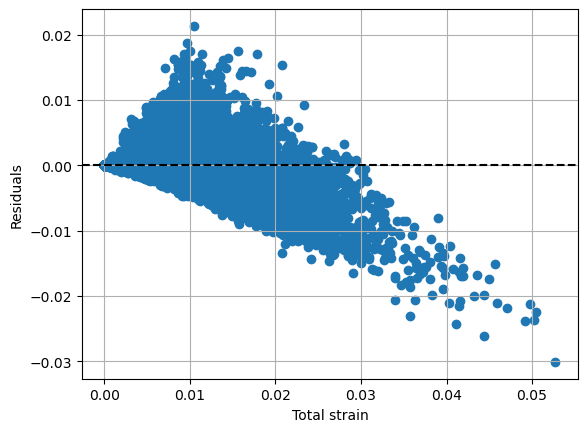

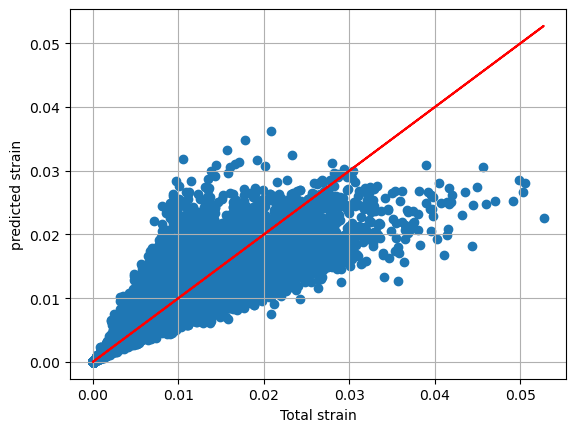

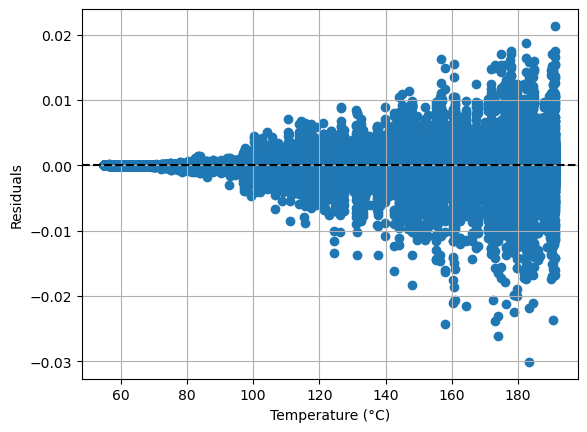

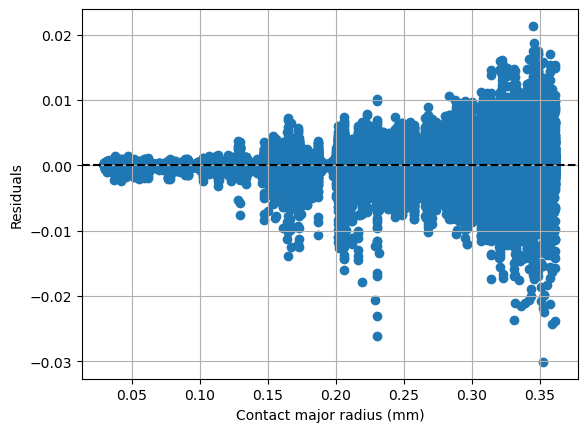

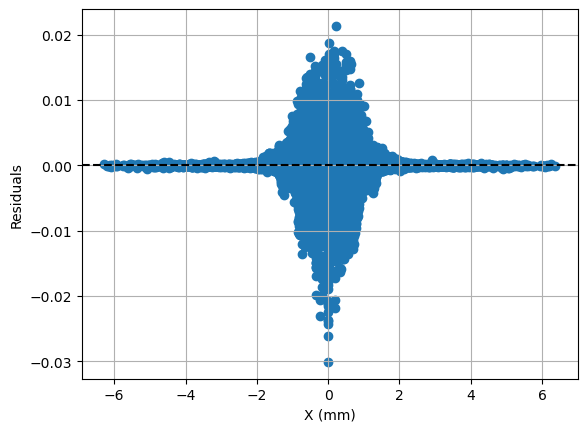

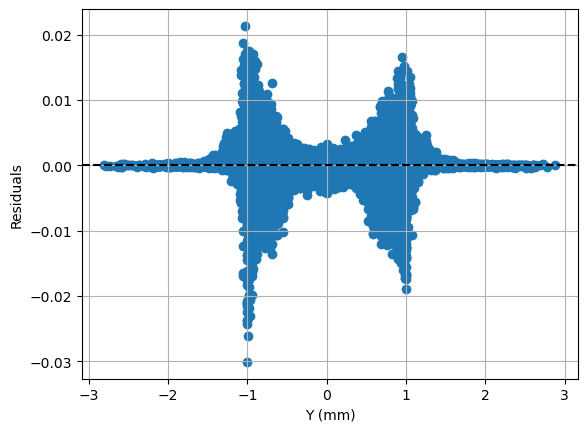

In [137]:
plot_residuals(X_test,y_hat,y_test,local_contact_data,Residual_variable_names,Output_names)